<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [1]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_categorical_procedures.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 1000

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [2]:
(# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=da9b9c96bdc8ccb6c5540203fdb7d844a122d0ec34af8f4bfbbcb86f415fd4ba
  Stored in directory: /root/.cache/pip/wheels/ab/fa/1b/75d9a713279796785711bd0bad8334aaace560c0bd28830c8c
  Created wheel for stringdist: filename=StringDist-1.0.9-cp39-cp39-linux_x86_64.whl size=24708 sha256=ca40eb750db6b0c26a02674189eb75465c39680a7abba7956a800ecf96745ad2
  Stored in directory: /root/.cache/pip/wheels/77/24/44/b12b9612fd07e141e6b4f1bb2001c621515bd0cac1014a783a
Successfully built intervaltree stringdist
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.8 MB/s eta 0:00:00


In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [5]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [6]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,156279,Left ICU,2133-10-29 21:27:49
1,147621,Left ICU,2186-08-30 18:53:52
2,147621,Left ICU,2186-09-07 13:07:40
3,169344,Left ICU,2183-02-06 16:47:32
4,130947,Left ICU,2137-09-05 13:48:35
...,...,...,...
56921,184122,Entered ICU,2187-12-13 20:13:48
56922,117135,Entered ICU,2184-07-11 20:52:46
56923,161999,Entered ICU,2128-08-27 15:02:12
56924,100197,Entered ICU,2136-10-23 16:23:52


## Section 2: Process Discovery

In [7]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-7-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')


Number of cases: 9057
Number of events: 56926
Start events: {'Admitted': 8946, 'Entered ICU': 92, 'Discharged': 10, 'Ventilation': 9}
End events: {'Discharged': 7390, 'Left ICU': 1667}


In [8]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [9]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 7296
Number of events: 44213
Start events: {'Admitted': 7296}
End events: {'Discharged': 7296}


In [10]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

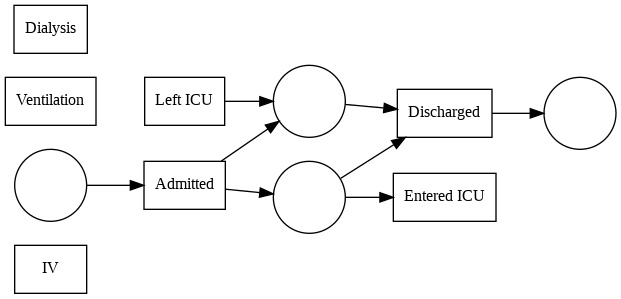

In [11]:
import graphviz
pm.view_petri_net(petri_net=net)

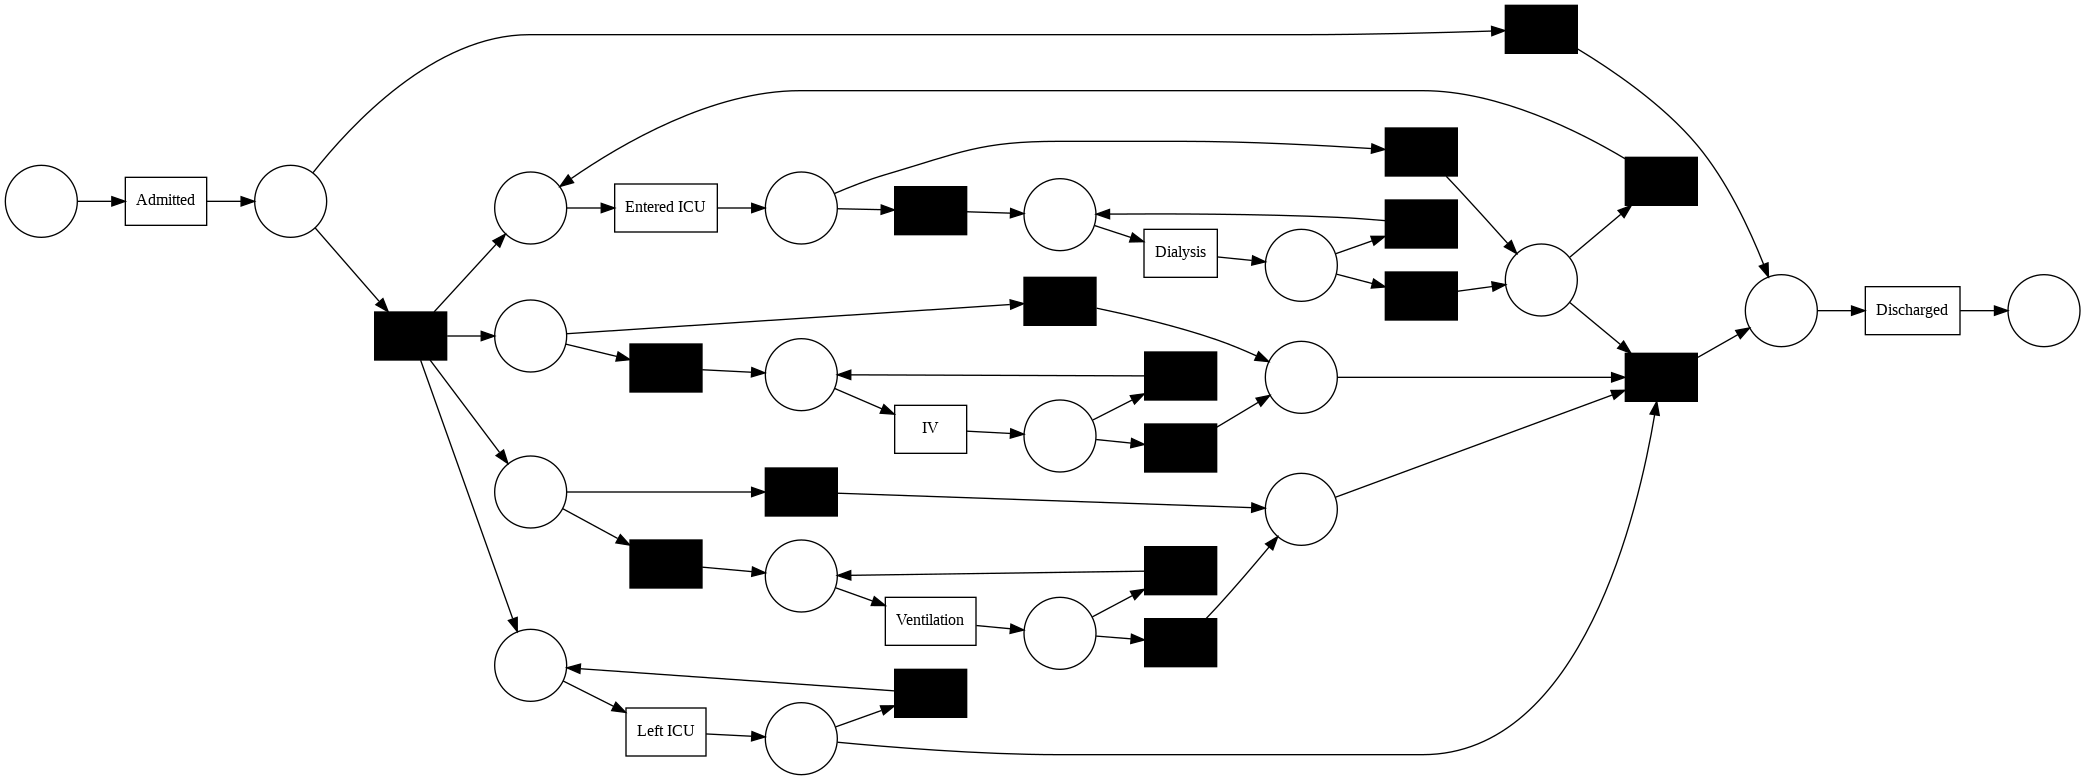

In [12]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

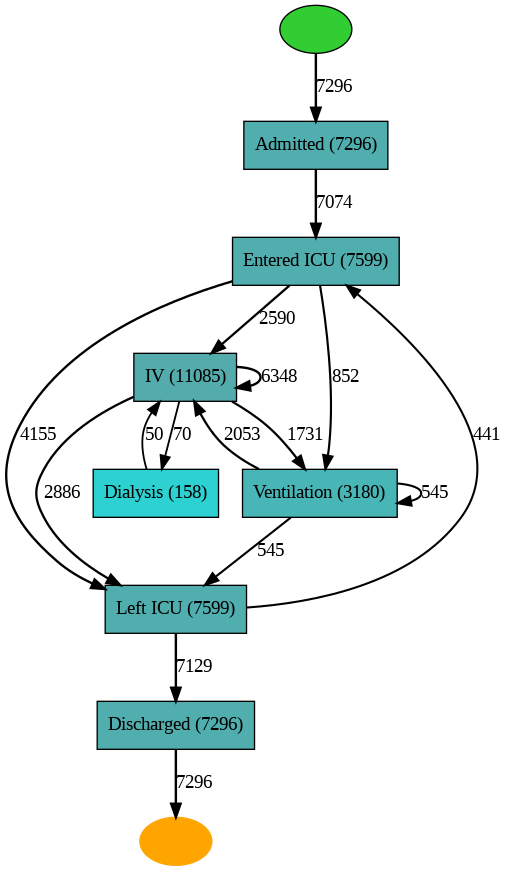

In [13]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

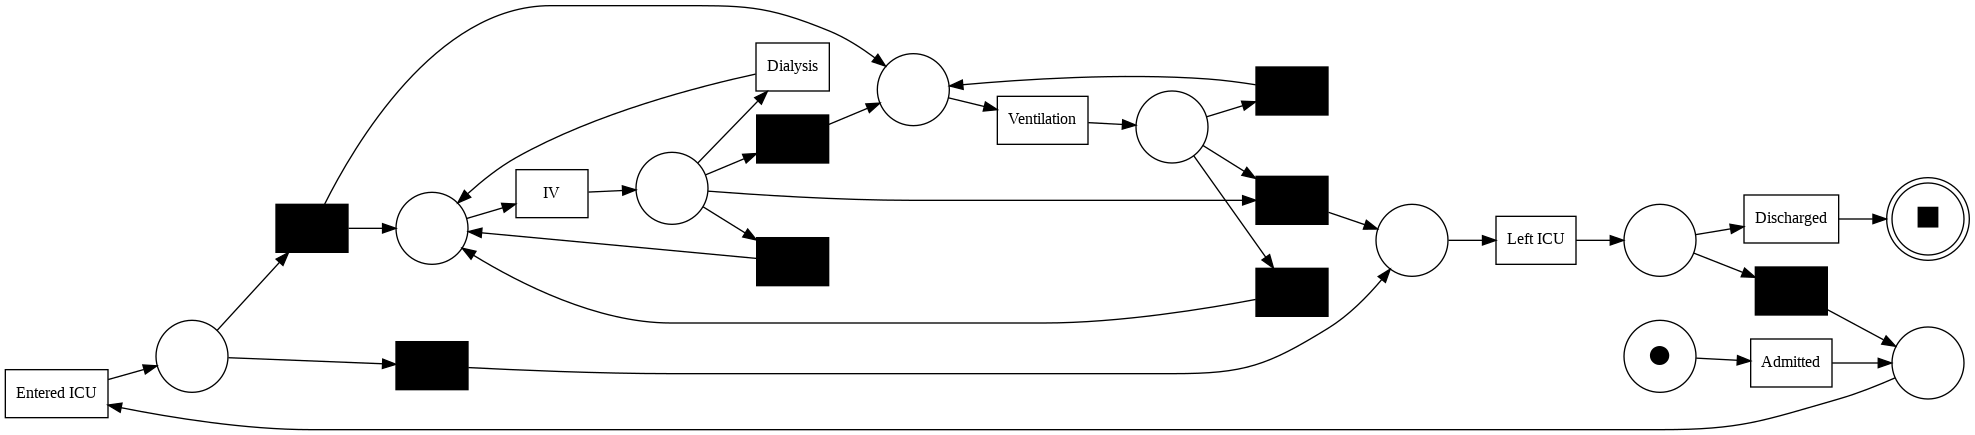

In [14]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

##Section 3: Preprocessing Data

In [15]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  # random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = el[el['trace'].isin(random_traces)]
  return partial_el


In [16]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,trace,activity,timestamp
122,18,Admitted,2152-09-10 14:08:00
123,18,Entered ICU,2152-09-10 14:09:20
124,18,IV,2152-09-10 15:30:00
125,18,IV,2152-09-10 17:52:00
126,18,Left ICU,2152-09-11 17:49:47
...,...,...,...
44204,7294,IV,2182-02-06 16:59:00
44205,7294,Ventilation,2182-02-06 21:57:00
44206,7294,IV,2182-02-07 16:02:00
44207,7294,Left ICU,2182-02-07 18:28:49


In [17]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity

({'Admitted': '1',
  'Entered ICU': '2',
  'IV': '3',
  'Left ICU': '4',
  'Discharged': '5',
  'Ventilation': '6',
  'Dialysis': '7'},
 {'1': 'Admitted',
  '2': 'Entered ICU',
  '3': 'IV',
  '4': 'Left ICU',
  '5': 'Discharged',
  '6': 'Ventilation',
  '7': 'Dialysis'})

In [18]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,trace,activity,timestamp
205,31,Admitted,2103-07-21 07:53:00
206,31,Entered ICU,2103-07-21 08:07:53
207,31,Left ICU,2103-07-25 10:40:25
208,31,Discharged,2103-07-26 16:05:00
801,125,Admitted,2170-10-22 21:57:00
...,...,...,...
42843,7067,Discharged,2172-07-16 16:15:00
43773,7218,Admitted,2181-01-21 21:12:00
43774,7218,Entered ICU,2181-01-21 21:15:11
43775,7218,Left ICU,2181-01-26 14:48:31


In [19]:
# find the first timestamp in dataset
start_time = partial_el['timestamp'].min()

In [20]:
import numpy as np

# transform train data into prefix, suffix and label
def label_train(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  
  for t in unique_traces:
    df = el[:][el.trace == t].sort_values(by='timestamp')
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = (df['timestamp'][i] - start_time).total_seconds() / 10_000_000_000
      timestamps.append(timestamp)
    
    length = len(activities)
    
    for i in range(length):
      label = activities[i]
      time_label = timestamps[i]
      prefix = activities[:i]
      prefix_times = timestamps[:i]

      suffix = []
      suffix_times = []

      if i != length - 1:
        suffix = activities[i+1:]
        suffix_times = timestamps[i+1:]

      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      padding = []
      
      while len(prefix_times) + len(padding) < PREFIX_LENGTH:
        padding.append(0.0)
      
      prefix_times =  padding + prefix_times

      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      while len(suffix_times) < PREFIX_LENGTH:
        suffix_times.append(0.0)
      
      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      prefix_times_arr.append(np.array(prefix_times[0:PREFIX_LENGTH], dtype=np.double))
      suffix_times_arr.append(np.array(suffix_times[0:PREFIX_LENGTH], dtype=np.double))
      label_arr.append(label)
      label_times_arr.append(time_label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix times' : prefix_times_arr,
                       'suffix times' : suffix_times_arr,
                       'activity label' : label_arr,
                       'time label': label_times_arr})
  

labeled_train_el = label_train(train_el)
labeled_train_el

,prefix,suffix,prefix times,suffix times,activity label,time label
0,"[0, 0, 0, 0, 0]","[2, 3, 3, 4, 5]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.16429301, 0.164293494, 0.164294346, 0.16430...",1,0.164293
1,"[0, 0, 0, 0, 1]","[3, 3, 4, 5, 0]","[0.0, 0.0, 0.0, 0.0, 0.164293002]","[0.164293494, 0.164294346, 0.1643029727, 0.164...",2,0.164293
2,"[0, 0, 0, 1, 2]","[3, 4, 5, 0, 0]","[0.0, 0.0, 0.0, 0.164293002, 0.16429301]","[0.164294346, 0.1643029727, 0.164310378, 0.0, ...",3,0.164293
3,"[0, 0, 1, 2, 3]","[4, 5, 0, 0, 0]","[0.0, 0.0, 0.164293002, 0.16429301, 0.164293494]","[0.1643029727, 0.164310378, 0.0, 0.0, 0.0]",3,0.164294
4,"[0, 1, 2, 3, 3]","[5, 0, 0, 0, 0]","[0.0, 0.164293002, 0.16429301, 0.164293494, 0....","[0.164310378, 0.0, 0.0, 0.0, 0.0]",4,0.164303
...,...,...,...,...,...,...
4395,"[1, 2, 6, 3, 3]","[6, 3, 4, 5, 0]","[0.257082774, 0.2570943293, 0.257095674, 0.257...","[0.257098056, 0.257104566, 0.2571054469, 0.257...",3,0.257096
4396,"[1, 2, 6, 3, 3]","[3, 4, 5, 0, 0]","[0.257082774, 0.2570943293, 0.257095674, 0.257...","[0.257104566, 0.2571054469, 0.257130054, 0.0, ...",6,0.257098
4397,"[1, 2, 6, 3, 3]","[4, 5, 0, 0, 0]","[0.257082774, 0.2570943293, 0.257095674, 0.257...","[0.2571054469, 0.257130054, 0.0, 0.0, 0.0]",3,0.257105
4398,"[1, 2, 6, 3, 3]","[5, 0, 0, 0, 0]","[0.257082774, 0.2570943293, 0.257095674, 0.257...","[0.257130054, 0.0, 0.0, 0.0, 0.0]",4,0.257105


In [21]:
labeled_train_el, validation_el = train_test_split(labeled_train_el, test_size=VALIDATION_SIZE, random_state=9)

In [22]:
def format_input(el):
  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  prefix_t = np.array(el['prefix times'])
  prefix_t = np.stack(prefix_t)
  prefix_t = prefix_t.reshape(prefix_t.shape[0], prefix_t.shape[1], 1)

  suffix_t = np.array(el['suffix times'])
  suffix_t = np.stack(suffix_t)
  suffix_t = suffix_t.reshape(suffix_t.shape[0], suffix_t.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x], [prefix_t], [suffix_t]))

  y = np.array(el['time label'])
  y = np.stack(y)

  return x, y 

In [23]:
train_x, train_y = format_input(labeled_train_el)
validation_x, validation_y = format_input(validation_el)

In [24]:
from copy import deepcopy

def random_remove(el):
  unique_traces_test = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = deepcopy(test_el[:][test_el.trace == t])
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(0,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,2])
    trace_df.iat[rand_index, 2] = np.nan
    df = pd.concat([df, trace_df])

  return df, targets

In [25]:
test_x, test_y = random_remove(test_el)
test_x

,trace,activity,timestamp
205,31,Admitted,2103-07-21 07:53:00
206,31,Entered ICU,2103-07-21 08:07:53
207,31,Left ICU,2103-07-25 10:40:25
208,31,Discharged,NaT
801,125,Admitted,NaT
...,...,...,...
42843,7067,Discharged,2172-07-16 16:15:00
43773,7218,Admitted,2181-01-21 21:12:00
43774,7218,Entered ICU,NaT
43775,7218,Left ICU,2181-01-26 14:48:31


##Section 4: Predicting the correct sequence order

###4.1 Creating process model using training set

<ipython-input-26-916819195737>:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

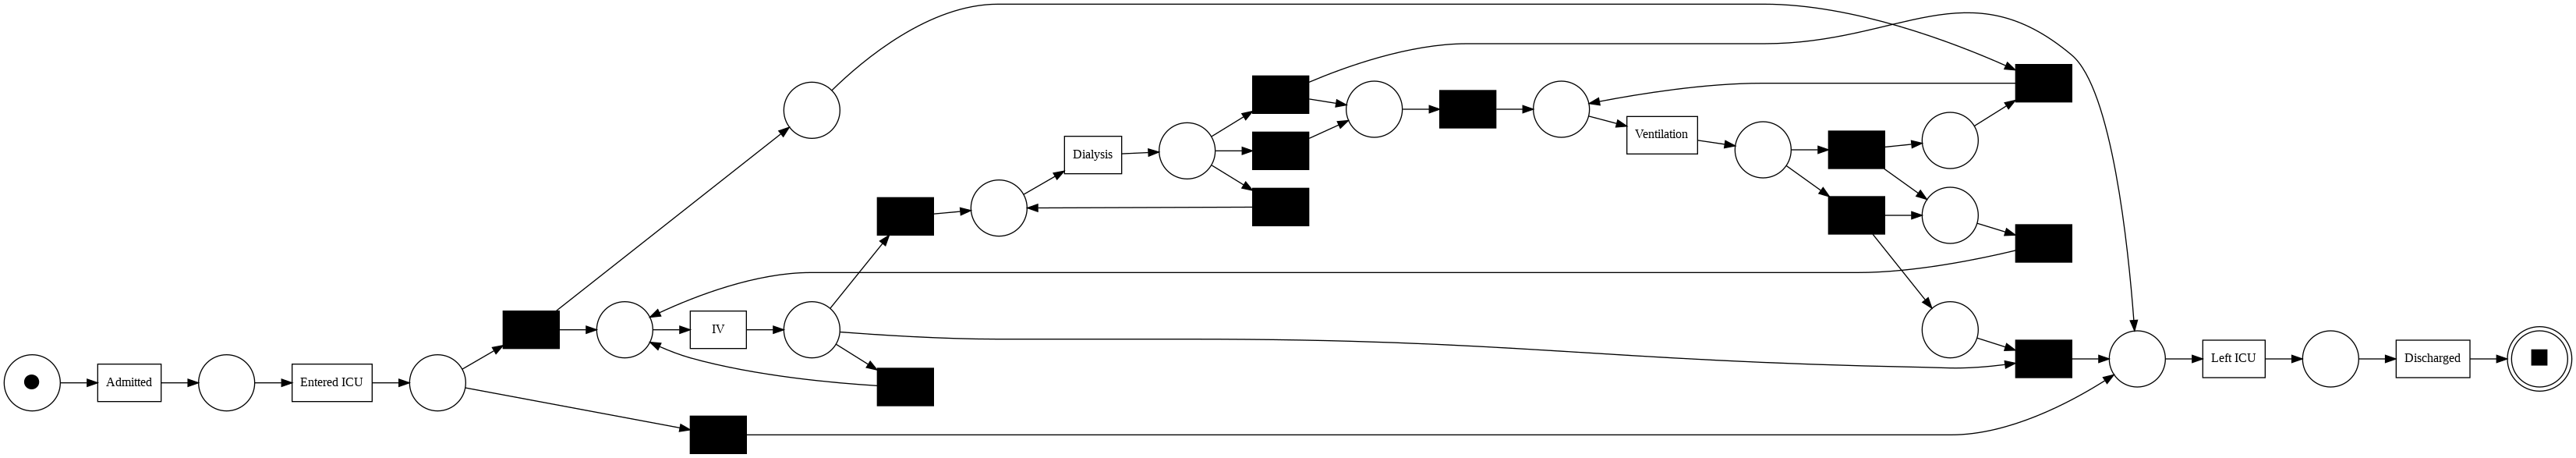

In [26]:
# format train event log as pm4py event log
train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
# petri net from heuristics miner
heuristic_net, heuristic_im, heuristic_fm = pm.discover_petri_net_heuristics(train_log, dependency_threshold=0)
pm.view_petri_net(heuristic_net, heuristic_im, heuristic_fm)

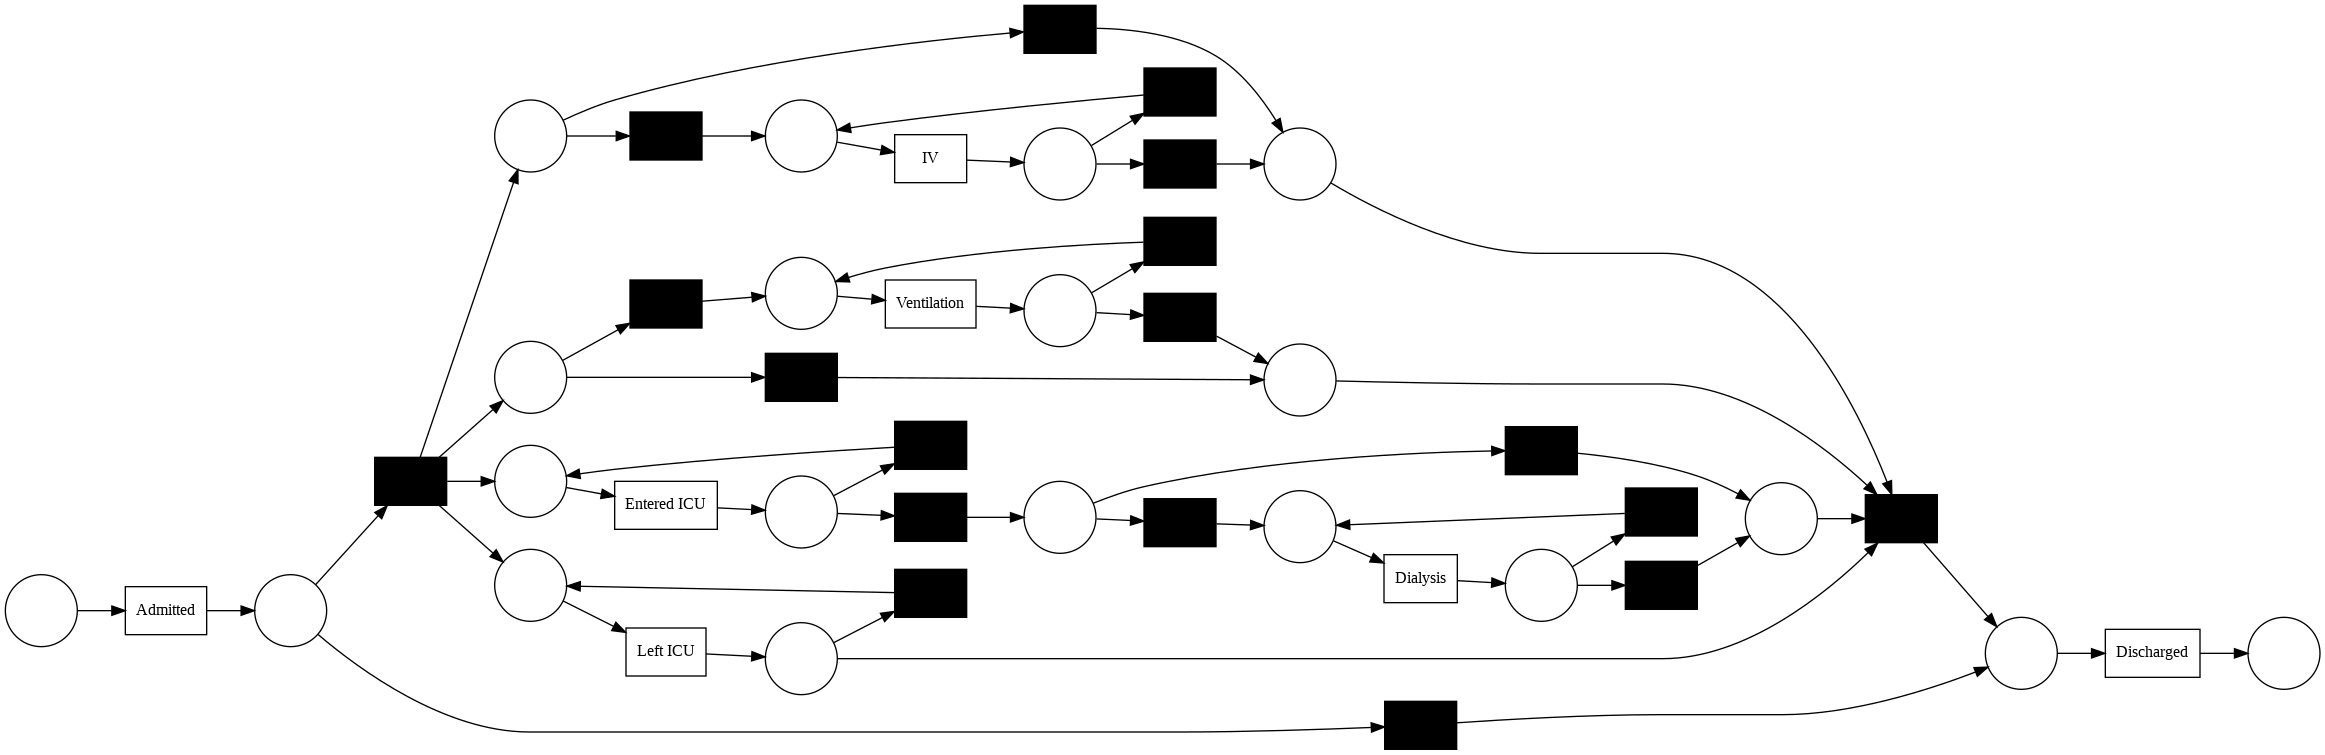

In [27]:
inductive_net, inductive_im, inductive_fm = pm.discover_petri_net_inductive(train_log)
pm.view_petri_net(petri_net=inductive_net)

<ipython-input-28-1ff381e6b524>:1: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. this method will be removed in a future release.
  alpha_net, alpha_im, alpha_fm = pm.discover_petri_net_alpha_plus(train_log)


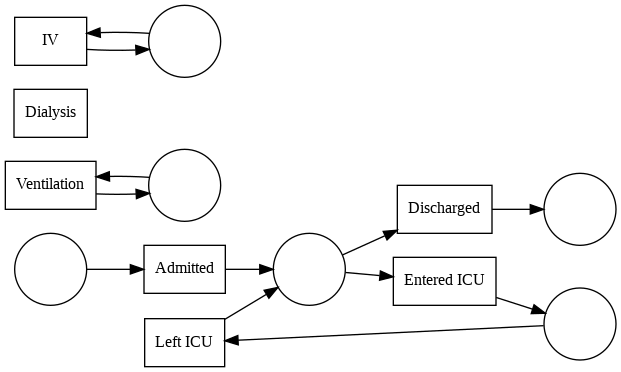

In [28]:
alpha_net, alpha_im, alpha_fm = pm.discover_petri_net_alpha_plus(train_log)
pm.view_petri_net(petri_net=alpha_net)

###4.2

In [72]:
def replay_trace(el, pn, im, fm):
  # log = pm.format_dataframe(el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
  replay_result_token = pm.fitness_token_based_replay(el, pn, im, fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  replay_result_alignments = pm.fitness_alignments(el, pn, im, fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  # print(replay_result_alignments)
  return replay_result_token['average_trace_fitness'], replay_result_alignments['average_trace_fitness']

In [67]:
def generate_traces(sequence, missing, trace, pn, im, fm):
    timestamps = sequence['timestamp'].tolist()
    if missing.iat[0,1] == 'Admitted':
      return pd.concat([missing,sequence], ignore_index=True), pd.concat([missing,sequence], ignore_index=True) 
    if missing.iat[0,1] == 'Discharged':
      return pd.concat([sequence,missing], ignore_index=True), pd.concat([sequence,missing], ignore_index=True)
     
    trace_length = len(timestamps) -1
    best_fitness_token = 0
    best_fitness_alignments = 0
    best_trace_token = None
    best_trace_alignments = None

    for i in range(1,trace_length+1):

      df = pd.concat([sequence.head(i), missing, sequence.tail(trace_length-i+1)], ignore_index=True)
      inputed_df = deepcopy(df)
      previous_timestamp = inputed_df.iat[i-1,2]
      next_timestamp = inputed_df.iat[i+1,2]
      inputed_timestamp = previous_timestamp + (next_timestamp-previous_timestamp)/2 
      inputed_df.iat[i,2] = inputed_timestamp
      # print(inputed_df)
      fitness_token, fitness_alignments = replay_trace(inputed_df, pn, im, fm)

      # fitness = 1
      if fitness_token > best_fitness_token:
        best_fitness_token = fitness_token
        best_trace_token = df
      
      if fitness_alignments > best_fitness_alignments:
        best_fitness_alignments = fitness_alignments
        best_trace_alignments = df


    return best_trace_token, best_trace_alignments


In [70]:
def predict_sequences(el, pn, im, fm):
  df_token = pd.DataFrame(columns=['trace','activity','timestamp'])
  df_alignments = pd.DataFrame(columns=['trace','activity','timestamp'])

  unique_traces = el['trace'].unique()

  for t in unique_traces:
    trace_df = el[:][test_el.trace == t]
    sequence = trace_df.loc[trace_df['timestamp'].notna()]
    missing = trace_df.loc[trace_df['timestamp'].isna()]
    # print(t)
    predicted_trace = generate_traces(sequence, missing, t, pn, im, fm)
    df_token = pd.concat([df_token,predicted_trace[0]], ignore_index=True)
    df_alignments = pd.concat([df_alignments, predicted_trace[1]], ignore_index=True)

  return df_token, df_alignments



In [76]:
alpha_sequences_token, alpha_sequences_alignments = predict_sequences(test_x, alpha_net, alpha_im, alpha_fm)
heuristic_sequences_token, heuristic_sequences_alignments = predict_sequences(test_x, heuristic_net, heuristic_im, heuristic_fm)
inductive_sequences_token, inductive_sequences_alignments = predict_sequences(test_x, inductive_net, inductive_im, inductive_fm)

###4.3 evaluate sequence prediction

In [77]:
def evaluate_sequences(predicted, targets):
  correct, incorrect, error = 0, 0, 0
  unique_traces = targets['trace'].unique()
  
  for trace in unique_traces:
    t = targets[:][targets.trace == trace]
    target = t.index[t['timestamp'].isnull()][0]
    p = predicted[:][predicted.trace == trace]
    prediction = p.index[p['timestamp'].isnull()][0]
    
    if prediction == target:
      correct += 1
    else:
      incorrect += 1
      error += (prediction - target)**2
    

  accuracy = correct / (correct + incorrect)
  rmse = (error / len(unique_traces)) ** 0.5

  return accuracy, rmse


print(f"Heuristic token based replay: {evaluate_sequences(test_x.reset_index(), heuristic_sequences_token.reset_index())}")
print(f"Inductive token based replay: {evaluate_sequences(test_x.reset_index(), inductive_sequences_token.reset_index())}")
print(f"Alpha token based replay: {evaluate_sequences(test_x.reset_index(), alpha_sequences_token.reset_index())}")

print(f"Heuristic alignments: {evaluate_sequences(test_x.reset_index(), heuristic_sequences_alignments.reset_index())}")
print(f"Inductive alignments: {evaluate_sequences(test_x.reset_index(), inductive_sequences_alignments.reset_index())}")
print(f"Alpha alignments: {evaluate_sequences(test_x.reset_index(), alpha_sequences_alignments.reset_index())}")





Heuristic token based replay: (0.7165775401069518, 1.884357221717112)
Inductive token based replay: (0.5882352941176471, 2.671897721312528)
Alpha token based replay: (0.7379679144385026, 2.4319618629151645)
Heuristic alignments: (0.732620320855615, 2.433061054773736)
Inductive alignments: (0.5882352941176471, 2.671897721312528)
Alpha alignments: (0.7379679144385026, 2.4319618629151645)


###4.4 Finish pre-processing test data

In [78]:
def label_test(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    df = el[:][el.trace == t]
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i]
      # if pd.isnull(timestamp):
      timestamp =  (df['timestamp'][i] - start_time).total_seconds() / 10_000_000_000

      timestamps.append(timestamp)
    
    # print(timestamps)

    length = len(timestamps)
    order = 0
    for i in range(length):
      if pd.isnull(timestamps[i]):
        order = i
        break

    # print(order)

    label = activities[order]
    time_label = timestamps[order]
    prefix = activities[:order]
    prefix_times = timestamps[:order]

    # print(prefix_times)

    suffix, suffix_times = [], []

    if i != length - 1:
      suffix = activities[i+1:]
      suffix_times = timestamps[i+1:]

    padding = []

    while len(prefix) + len(padding) < PREFIX_LENGTH:
      padding.append('0')
    
    prefix = padding + prefix
      
    padding = []
    
    while len(prefix_times) + len(padding) < PREFIX_LENGTH:
      padding.append(0.0)
    
    prefix_times =  padding + prefix_times

    while len(suffix) < PREFIX_LENGTH:
      suffix.append('0')

    while len(suffix_times) < PREFIX_LENGTH:
      suffix_times.append(0.0)

    # f = '%Y-%d-%m %H:%M:%S'
    # for i in range(PREFIX_LENGTH):
    #   try:
    #     prefix_times[i] = pd.to_datetime(prefix_times[i], format=f).value
    #     # suffix_times[i] = pd.to_datetime(suffix_times[i], format=f).value
    #   except ValueError:
    #     continue

    # for i in range(PREFIX_LENGTH):
    #   try:
    #     # prefix_times[i] = pd.to_datetime(prefix_times[i], format=f).value
    #     suffix_times[i] = pd.to_datetime(suffix_times[i], format=f).value
    #   except ValueError:
    #     continue

    prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
    suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
    prefix_times_arr.append(np.array(prefix_times[:PREFIX_LENGTH], dtype=np.double))
    suffix_times_arr.append(np.array(suffix_times[:PREFIX_LENGTH], dtype=np.double))
    label_arr.append(label)
    label_times_arr.append(time_label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix times' : prefix_times_arr,
                       'suffix times' : suffix_times_arr,
                       'activity label' : label_arr,
                       'time label': label_times_arr})


In [80]:
labeled_test = label_test(heuristic_sequences_token)
test_x, _ = format_input(labeled_test)


##Section 5: Naiive timestamp imputation method

In [ ]:
# calculate mean time delta for discharge and admission
def admission_discharge_delta(el):
  discharge_delta, admission_delta = 0, 0
  unique_traces = el['trace'].unique()
  n = len(unique_traces)

  for t in unique_traces:
    df = el[:][el.trace == t]
    timestamps = [], []

    for i in df.index:
      timestamp = (df['timestamp'][i]).total_seconds()
      timestamps.append(timestamp)
    
    admission_delta += timestamps[1] - timestamps[0]
    discharge_delta += timestamps[-1] - timestamps[-2]

  mean_admission_delta = admission_delta/n
  mean_discharge_delta = discharge_delta/n


  # return 

  


admission_discharge_delta(train_x)

In [81]:
def naiive(p, s):
  predictions = []
  for i in range(len(p)):
    # print(i,':')
    # print(p[i][-1])
    # print(start_time + pd.to_timedelta(p[i][-1] * 10_000_000_000, unit='s'))
    # print(s[i][0])
    # print(start_time + pd.to_timedelta(s[i][0] * 10_000_000_000, unit='s'))

    if p[i][-1] != 0.0 and s[i][0] != 0:
      prediction = p[i][-1] + (s[i][0] - p[i][-1])/2
      seconds = start_time + pd.to_timedelta(prediction * 10_000_000_000, unit='s')
      predictions.append(seconds)
    else:
      predictions.append(-1)

  return predictions
    
naiive(test_x[2], test_x[3])

[-1,
 -1,
 DatetimeIndex(['2114-07-12 05:29:59.999999940'], dtype='datetime64[ns]', freq=None),
 -1,
 DatetimeIndex(['2193-08-15 00:43:00'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2187-04-13 11:22:59.999999523'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2145-03-09 23:39:05'], dtype='datetime64[ns]', freq=None),
 -1,
 DatetimeIndex(['2175-07-11 18:35:00'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2193-09-14 13:28:14'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2192-10-20 15:52:30'], dtype='datetime64[ns]', freq=None),
 -1,
 DatetimeIndex(['2188-11-21 23:31:01.500000'], dtype='datetime64[ns]', freq=None),
 -1,
 DatetimeIndex(['2117-03-22 11:51:29.999999940'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2120-04-23 18:19:53.500000'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2131-12-12 06:40:00'], dtype='datetime64[ns]', freq=None),
 -1,
 DatetimeIndex(['2191-04-29 14:00:30'], dtype='datetime64[ns]', freq=None),
 -1,
 Dat

In [82]:
test_y

[Timestamp('2103-07-26 16:05:00'),
 Timestamp('2170-10-22 21:57:00'),
 Timestamp('2114-07-11 16:53:00'),
 Timestamp('2193-10-20 14:18:00'),
 Timestamp('2193-08-20 17:45:54'),
 Timestamp('2187-04-11 11:26:00'),
 Timestamp('2145-03-09 11:27:17'),
 Timestamp('2180-01-25 14:07:00'),
 Timestamp('2175-07-11 00:02:00'),
 Timestamp('2193-09-14 17:17:00'),
 Timestamp('2192-10-21 16:53:22'),
 Timestamp('2118-10-06 12:30:00'),
 Timestamp('2188-11-22 11:00:00'),
 Timestamp('2172-12-11 16:00:00'),
 Timestamp('2117-03-22 15:28:00'),
 Timestamp('2120-04-23 21:34:00'),
 Timestamp('2131-12-11 23:22:00'),
 Timestamp('2201-06-30 01:40:00'),
 Timestamp('2191-05-01 10:00:00'),
 Timestamp('2170-10-22 16:37:00'),
 Timestamp('2190-03-09 02:02:57'),
 Timestamp('2148-05-30 10:25:46'),
 Timestamp('2167-11-10 13:14:00'),
 Timestamp('2135-02-08 20:32:54'),
 Timestamp('2201-03-28 09:59:30'),
 Timestamp('2150-02-20 13:30:11'),
 Timestamp('2170-02-20 10:00:36'),
 Timestamp('2160-03-13 12:12:18'),
 Timestamp('2183-02-

In [ ]:
# def evaluate

## Section 6: Predicting timestamp using LSTM 

In [ ]:
from keras.layers import Dropout, Input, Bidirectional, LSTM, average, Dense
from keras import Model

prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_times_input')
suffix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_times_input')

lstm_layer = LSTM(96)

prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_times_lstm = Bidirectional(lstm_layer, name='prefix_times_lstm')(prefix_times_input)
suffix_times_lstm = Bidirectional(lstm_layer, name='suffix_times_lstm')(suffix_times_input)


dropout_prefix_events = Dropout(0.2)(prefix_events_lstm)
dropout_suffix_events = Dropout(0.2)(suffix_events_lstm)
dropout_prefix_times = Dropout(0.2)(prefix_times_lstm)
dropout_suffix_times = Dropout(0.2)(suffix_times_lstm)


merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_times, dropout_suffix_times], name='merged')

output = Dense(1, name='output')(merged)

best_model = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_times_input, suffix_times_input],
    outputs=output)
best_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
best_model.summary()
best_model.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=30)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_times_input (InputLayer  [(None, 5, 1)]      0           []                               
 )                                                                                            

##Section 7: Evaluating the model

In [ ]:
def mean_squared_error(predictions):
  seconds, minutes, hours, days = 0, 0, 0, 0
  for p, t in zip(predictions, test_y):
    seconds += (p-t).total_seconds() ** 2
  seconds = (seconds / len(predictions)) ** 0.5
  minutes = seconds / 60
  hours = minutes / 60
  days = hours / 24
  years = days / 365
  return seconds, minutes, hours, days, years


In [ ]:
def predict(model):
  predictions = model.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
  predicted_times = []
  for prediction in predictions:
    seconds = start_time + pd.to_timedelta(prediction * 10_000_000_000, unit='s')
    predicted_times.append(seconds)
  return predicted_times
predictions = predict(best_model)

7/7 [==============================] - 0s 5ms/step


In [ ]:
mean_squared_error(predictions)

(Float64Index([143576924.2120714], dtype='float64'),
 Float64Index([2392948.7368678567], dtype='float64'),
 Float64Index([39882.47894779761], dtype='float64'),
 Float64Index([1661.7699561582338], dtype='float64'),
 Float64Index([4.552794400433517], dtype='float64'))

In [ ]:
predictions

[DatetimeIndex(['2161-07-16 00:46:48.527297974'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2192-10-15 07:46:08.134613037'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2167-04-19 13:42:26.318359375'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2162-01-17 19:32:19.365310669'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2166-04-11 23:41:09.768066406'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2134-11-19 03:38:42.391433716'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2119-02-05 06:37:30.166435242'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2143-02-12 20:13:21.694793701'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2151-06-06 09:29:23.589019775'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2119-10-22 11:34:12.359504700'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2164-11-11 19:04:03.326492310'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2165-05-30 09:57:23.338699341'], dtyp

In [ ]:
test_y

[Timestamp('2161-10-29 13:24:41'),
 Timestamp('2186-07-20 09:37:09'),
 Timestamp('2169-10-21 13:37:00'),
 Timestamp('2164-06-22 16:30:00'),
 Timestamp('2168-08-17 19:43:00'),
 Timestamp('2133-04-05 15:21:07'),
 Timestamp('2114-05-17 20:24:00'),
 Timestamp('2141-11-16 17:00:00'),
 Timestamp('2149-09-20 09:33:31'),
 Timestamp('2116-12-13 21:45:00'),
 Timestamp('2191-02-17 13:48:00'),
 Timestamp('2167-12-27 19:35:00'),
 Timestamp('2173-02-22 13:20:00'),
 Timestamp('2160-11-07 14:21:38'),
 Timestamp('2163-10-28 14:45:00'),
 Timestamp('2158-08-18 16:11:59'),
 Timestamp('2102-10-18 14:35:00'),
 Timestamp('2165-04-09 10:48:00'),
 Timestamp('2173-01-31 19:19:00'),
 Timestamp('2192-04-24 15:55:00'),
 Timestamp('2130-08-29 17:10:40'),
 Timestamp('2105-06-02 16:36:00'),
 Timestamp('2188-04-21 21:21:00'),
 Timestamp('2124-11-05 14:44:13'),
 Timestamp('2188-09-26 13:29:14'),
 Timestamp('2155-04-23 16:18:27'),
 Timestamp('2134-06-12 15:24:49'),
 Timestamp('2114-10-26 13:37:21'),
 Timestamp('2161-01-